In [24]:
# Import modules
import datetime
import spiceypy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Clear any previously loaded kernels
spiceypy.kclear()

# Load kernels via meta file
spiceypy.furnsh('kernel_meta.txt')
print("Meta Kernel Loaded:", spiceypy.ktotal("ALL"))

# Manually load kernels (in correct order)
spiceypy.furnsh('../kernels/lsk/naif0012.tls')  # Leap Seconds
spiceypy.furnsh('../kernels/spk/de432s.bsp')    # Ephemeris Data
spiceypy.furnsh('../kernels/pck/pck00010.tpc')  # Planet Constants

# Verify total loaded kernels
print("Total Kernels Loaded:", spiceypy.ktotal("ALL"))

# Create an initial date-time object that is converted to a string
datetime_utc = datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')

# Convert to Ephemeris Time (ET) using the SPICE function utc2et
datetime_et = spiceypy.utc2et(datetime_utc)

Meta Kernel Loaded: 1
Total Kernels Loaded: 4


In [ ]:
# We want to compute the coordinates for different Solar System bodies as seen
# from our planet. First, a pandas dataframe is set that is used to append the
# computed data
solsys_df = pd.DataFrame()

# Add the ET and the corresponding UTC date-time string
solsys_df.loc[:, 'ET'] = [datetime_et]
solsys_df.loc[:, 'UTC'] = [datetime_utc]

# Set a dictionary that lists some body names and the corresponding NAIF ID
# code. Mars has the ID 499, however the loaded kernels do not contain the
# positional information. We use the Mars barycentre instead
SOLSYS_DICT = {'SUN': 10, 'VENUS': 299, 'MOON': 301, 'MARS': 4}

In [26]:
# Iterate through the dictionary and compute miscellaneous positional
# parameters
for body_name in SOLSYS_DICT:

    # First, compute the directional vector Earth - body in ECLIPJ2000. Use
    # LT+S light time correction. spkezp returns the directional vector and
    # light time. Apply [0] to get only the vector
    solsys_df.loc[:, f'dir_{body_name}_wrt_earth_ecl'] = \
        solsys_df['ET'].apply(lambda x: spiceypy.spkezp(targ=SOLSYS_DICT[body_name], \
                                                        et=x, \
                                                        ref='ECLIPJ2000', \
                                                        abcorr='LT+S', \
                                                        obs=399)[0])

    # Compute the longitude and latitude of the body in radians in ECLIPJ2000
    # using the function recrad. recrad returns the distance, longitude and
    # latitude value; thus, apply [1] and [2] to get the longitude and
    # latitude, respectively
    solsys_df.loc[:, f'{body_name}_long_rad_ecl'] = solsys_df[f'dir_{body_name}_wrt_earth_ecl'] \
                                                        .apply(lambda x: spiceypy.recrad(x)[1])

    solsys_df.loc[:, f'{body_name}_lat_rad_ecl'] = solsys_df[f'dir_{body_name}_wrt_earth_ecl'] \
                                                        .apply(lambda x: spiceypy.recrad(x)[2])

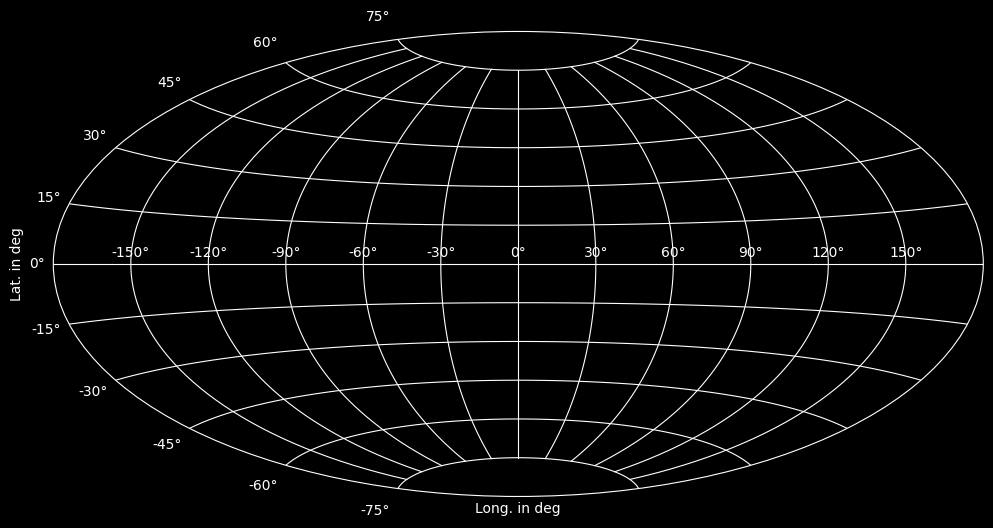

In [27]:
# Create an empty matplotlib example plot to show how matplotlib displays
# projected data

# Use a dark background
plt.style.use('dark_background')

# Set a figure
plt.figure(figsize=(12, 8))

# Apply the aitoff projection and activate the grid
plt.subplot(projection="aitoff")
plt.grid(True)

# Set long. / lat. labels
plt.xlabel('Long. in deg')
plt.ylabel('Lat. in deg')

# Save the figure
plt.savefig('empty_aitoff.png', dpi=300)

In [28]:
# Before we plot the data, we need to convert the longitude data into a
# matplotlib compatible format. We computed longitude values between 0 and
# 2*pi (360 degrees). matplotlib expects values between -pi and +pi. Further,
# sky maps count from 0 degrees longitude to the left. Thus we need also to
# invert the longitude values
for body_name in SOLSYS_DICT:

    solsys_df.loc[:, f'{body_name}_long_rad4plot_ecl'] = \
        solsys_df[f'{body_name}_long_rad_ecl'] \
            .apply(lambda x: -1*((x % np.pi) - np.pi) if x > np.pi \
                   else -1*x)

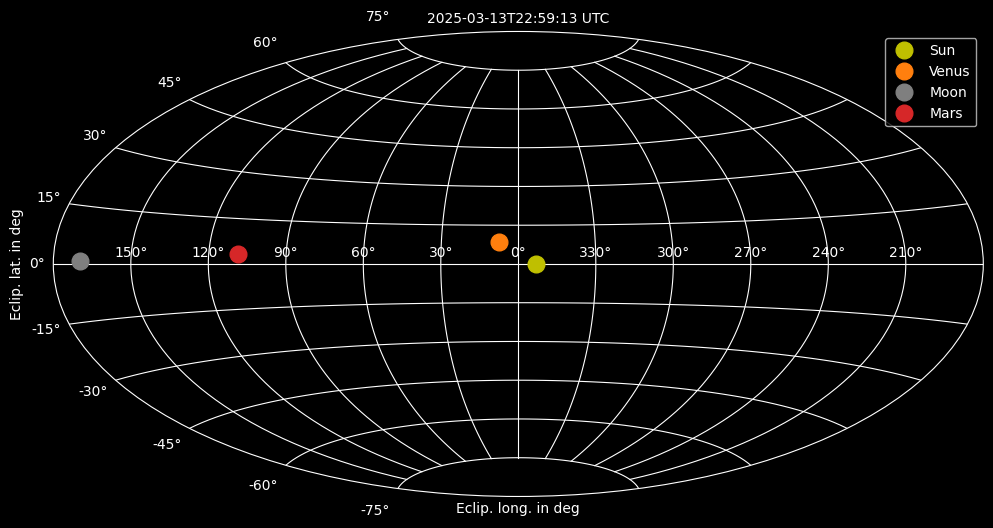

In [29]:
# Create now a sky map of the results

# Set a dark background (the night sky is ... dark)
plt.style.use('dark_background')

# Create a figure and then apply the aitoff projection
plt.figure(figsize=(12, 8))
plt.subplot(projection="aitoff")

# Set the UTC time string as a title
plt.title(f'{datetime_utc} UTC', fontsize=10)

# Each body shall have an individual color; set a list with some colors
BODY_COLOR_ARRAY = ['y', 'tab:orange', 'tab:gray', 'tab:red']

# Iterate through the pandas dataframe. And plot each celestial body
for body_name, body_color in zip(SOLSYS_DICT, BODY_COLOR_ARRAY):

    # Plot the longitude and latitude data. Apply the color, and other
    # formatting parameters
    plt.plot(solsys_df[f'{body_name}_long_rad4plot_ecl'], \
             solsys_df[f'{body_name}_lat_rad_ecl'], \
             color=body_color, marker='o', linestyle='None', markersize=12, \
             label=body_name.capitalize())

# Replace the standard x ticks (longitude) with the ecliptic coordinates
plt.xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, \
                             30, 60, 90, 120, 150]),
           labels=['150°', '120°', '90°', '60°', '30°', '0°', \
                   '330°', '300°', '270°', '240°', '210°'])

# Set the axes labels
plt.xlabel('Eclip. long. in deg')
plt.ylabel('Eclip. lat. in deg')

# Create a legend and grid
plt.legend()
plt.grid(True)

# Save the figure
plt.savefig('eclipj2000_sky_map.png', dpi=300)